# Modeling Reversal Task

### RW model of the reversal task in the aging experiment

The aim of this notebook is to see if age affects appetative reversal learning.

participants have 70 trials 40% reinforced.

reversal of stimuli occurs after 35 trials.

This notebook is based on Or's simulation of SCR.

Rescorla-Wagner model will follow the formula:

$$
V(n+1) = V(n) - α*PE
$$
$$
PE = V(n)-outcome
$$

## load libraries

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os

import pymc3 as pm
import arviz as az

from glob import glob

## Get data

make sure only participant with complete data set are loaded

In [2]:
age = pd.read_csv('../demo.csv')

In [3]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'

db = pd.DataFrame()

for sub in glob(glober):
    
    try:
        df = pd.read_csv(sub)
        df['sub'] = sub.split('_')[2]
        if df.shape[0] == 70:
            db = pd.concat([db, df], axis = 0)
            #db = db.append(df)#[df.trialNum<36])
    except:
        print(sub)
        print('error')

#db['rating'] = db['rating'].replace(0, np.nan)
db = db.sort_values(by=['sub','trialNum'])
print('number of subject: ', len(db['sub'].unique()))

number of subject:  95


In [4]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age, left_on='sub', right_on='sub')
db = db.sort_values('sub')
print('Valid subjects: ', len(np.unique(db['sub'])))

Valid subjects:  68


In [5]:
x = db[db['RT']==-1].groupby('sub').count()['rating']
x = x[x>5].reset_index()
print(x)
db = db[~db['sub'].isin(x['sub'].values)]

   sub  rating
0  102      13


In [6]:
subs = db.drop_duplicates('sub')
subs = subs.drop(['trialNum', 'rectOri', 'rectValue', 'rating', 'RT'],axis = 1).reset_index(drop=True)
subs.head()

,sub,gender,age,moca_score
0,10,M,18,28
1,11,F,43,26
2,13,F,48,28
3,14,F,26,30
4,15,F,58,26


In [7]:
db = db[db.trialNum<36]

## get descriptive data

In [8]:
n_subj   = len(db['sub'].unique())
n_trials = max(db.trialNum)

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj   = tt.as_tensor_variable(subj.T)

In [9]:
stim   = np.reshape([db['rectOri']],   (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']],    (n_subj, n_trials)).T

stim   = np.array(stim/45,  dtype='int')
reward = np.array(reward/6, dtype='int')

In [10]:
stim = tt.as_tensor_variable(stim)
reward = tt.as_tensor_variable(reward)

In [11]:
rating = [np.nan if 0 else x/9 for x in rating]

# create a pymc3 model

In [12]:
# generate functions to run
def update_Q(stim, reward,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = reward - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

In [13]:
# generate functions to run
def update_Q_hall(stim, reward,
             Qs,vec,alpha,assoc,
             eta,kappa, n_subj):
    """
    This function updates the Q table according to Hybrid PH model
    For information, please see this paper: https://www.sciencedirect.com/science/article/pii/S0896627316305840?via%3Dihub
  
    """
      
    delta = reward - Qs[tt.arange(n_subj), stim]
    alpha = tt.set_subtensor(alpha[tt.arange(n_subj), stim], eta * abs(delta) + (1-eta)*alpha[tt.arange(n_subj), stim])
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + kappa*alpha[tt.arange(n_subj), stim] * delta)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    # we use the same idea to get the associability per trial
    assoc = tt.set_subtensor(assoc[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                alpha[tt.arange(n_subj),1], alpha[tt.arange(n_subj),0])))
    
    return Qs, vec, alpha, assoc



In [14]:
# Rouhani et al. version https://elifesciences.org/articles/61077
# generate functions to run
def update_Q_r(stim, shock,
             Qs,vec,
             eta,kappa,n_subj):
    """
    This function updates the Q table according to Hybrid PH model
    For information, please see this paper: https://www.sciencedirect.com/science/article/pii/S0896627316305840?via%3Dihub
  
    """
      
    delta = shock - Qs[tt.arange(n_subj), stim]
    alpha = eta + (kappa * abs(delta))
    alpha = 1 / (1 + pm.math.exp(-alpha)) # sigmoid function
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * delta)
    
  
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
        
    return Qs, vec, alpha

In [15]:
# try alpha as beta distribution
with pm.Model() as model_B:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_b = pm.sample(tune=2000, draws=1000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1104 seconds.


In [16]:
# try with intercept
with pm.Model() as model_B_I:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_i = pm.sample(tune=2000, draws=1000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 934 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
# try with random intercept
with pm.Model() as model_B_r_I:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_ri = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 16782 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


## Hierarchal model

In [18]:
# try alpha as beta distribution
with pm.Model() as model_H:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_hB = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 20104 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# The Pearce-Hall Hybrid model

This is an attempt to build the PH Hybrid model.</br>
This model doesn't assume a simple constant learning rate (as the RW), rather, it incorporated both a constant learning rate and a dynamic one. </br>
The dynamic one is being updated by the amount of new information given.</br> 
The model goes like that: </br>
(1) Vi(k+1) = Vi (k) + κα(k)δ </br>
(2) δ = reward - Vi(k) </br>
(3) α(k+1) = η|δ|+(1-η)α(k)</br>

So the current value is an update of the previous one plus a constant learning rate (kappa) and an associability weight (α) (times the δ = prediction error). </br> 
The α is set by a constant weight of associability (η) and the previous α.


So now, our updating function will include those elements as well.

In [19]:
with pm.Model() as model_PH:
  
      
    eta = pm.Beta('eta', 2,2, shape=n_subj)
    kappa = pm.Beta('kappa', 2,2, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    # intercept
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64') # vector to save the relevant stimulus's expactation
    assoc = 0 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_Q_hall,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
    
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', mu = vec_, sd = eps, observed=rating) 
    
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_ph = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps, beta, kappa, eta]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5226 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
with pm.Model() as model_PH_h:
    
    # Hyper priors
    eta_a = pm.TruncatedNormal('eta_a', 1, 1, lower = 0.3)
    eta_b = pm.TruncatedNormal('eta_b', 1, 1, lower = 0.3)
    
    kappa_a = pm.TruncatedNormal('kappa_a', 1, 1, lower = 0.3)
    kappa_b = pm.TruncatedNormal('kappa_b', 1, 1, lower = 0.3)
      
    eta = pm.Beta('eta', eta_a, eta_b, shape=n_subj)
    kappa = pm.Beta('kappa', kappa_a, kappa_b, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    # intercept
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64') # vector to save the relevant stimulus's expactation
    assoc = 0 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_Q_hall,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
    
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', mu = vec_, sd = eps, observed=rating) 
    
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_ph_h = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps, beta, kappa, eta, kappa_b, kappa_a, eta_b, eta_a]


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 9786 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after

In [21]:
with pm.Model() as model_PH_R:
  
      
    eta = pm.Normal('eta', 0,1, shape=n_subj)
    kappa = pm.Normal('kappa', 0,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    # intercept
    #intercept = pm.Normal('intercept', 0, .5, shape=n_subj)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
  #  alpha = 0 * tt.ones((n_subj,2), dtype='float64') # vector to save the relevant stimulus's expactation
   # assoc = 0 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, alpha], updates = theano.scan(
        fn=update_Q_r,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, None],
        non_sequences=[eta, kappa, n_subj])
    
    vec_ = vec[trials, subj,0] * beta[subj]# + intercept[subj]
    
    learn = pm.Normal('learn', mu = vec_, sd = eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add associability
   # alpha = pm.Deterministic('pe', alpha)
    
    tr_ph_r = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, kappa, eta]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1538 seconds.


## model comparison

In [22]:
comp = az.compare({'basic model': tr_b, 'Model with intercept':tr_i, 'Model with random intercept':tr_ri, 'Hierarchical model': tr_hB, 'Pearce-Hall':tr_ph, 'Pearce-Hall Rouani': tr_ph_r,'Hierarchical Pearce-Hall':tr_ph_h}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hierarchical model,0,-362.429183,112.567634,0.000000,0.712022,29.065023,0.000000,False,log
Hierarchical Pearce-Hall,1,-365.863562,119.931019,3.434379,0.249092,28.993469,3.371894,False,log
Model with random intercept,2,-377.594166,147.114520,15.164982,0.000000,29.984590,5.974145,False,log
Pearce-Hall,3,-383.421423,130.009899,20.992239,0.000000,29.199707,4.242393,False,log
basic model,4,-391.927014,109.728715,29.497831,0.038887,29.983026,7.504869,False,log
Model with intercept,5,-432.702735,104.899765,70.273551,0.000000,28.097099,9.889462,False,log
Pearce-Hall Rouani,6,-441.402338,113.549836,78.973155,0.000000,30.564737,11.752652,False,log


<AxesSubplot:xlabel='Log'>

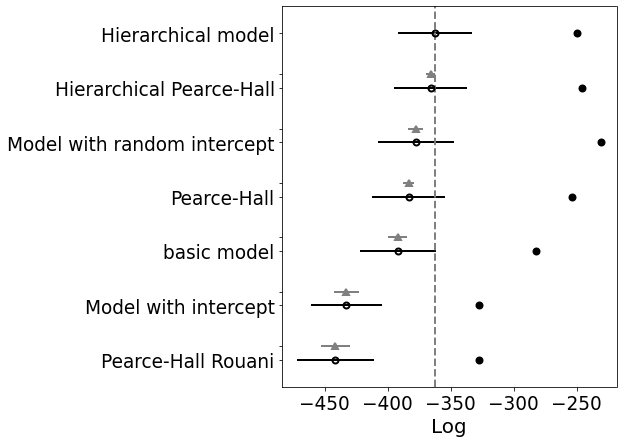

In [23]:
az.plot_compare(comp)

In [27]:
learning = db[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)


alpha = az.summary(tr_hB, var_names=['alpha'])[['mean']]
kappa = az.summary(tr_ph_h, var_names=['kappa'])[['mean']]
eta = az.summary(tr_ph_h, var_names=['eta'])[['mean']]

alpha = alpha.rename(columns={'mean': "alpha"}).reset_index(drop=True)
kappa = kappa.rename(columns={'mean': "kappa"}).reset_index(drop=True)
eta   =   eta.rename(columns={'mean': "eta"}).reset_index(drop=True)

learning = learning.merge(alpha, left_index=True, right_index=True)
learning = learning.merge(kappa, left_index=True, right_index=True)
learning = learning.merge(eta, left_index=True, right_index=True)

learning.head()

,sub,age,gender,moca_score,alpha,kappa,eta
0,10,18,M,28,0.165,0.155,0.819
1,11,43,F,26,0.173,0.241,0.833
2,13,48,F,28,0.139,0.140,0.818
3,14,26,F,30,0.149,0.164,0.824
4,15,58,F,26,0.156,0.187,0.837


In [29]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=y)

        likelihood = pm.StudentT(
            "likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y
        )

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [30]:
alpha_corr = corr(pd.DataFrame({'x': learning.age/100, 'y': learning.alpha}).reset_index(drop=True))
Kappa_corr = corr(pd.DataFrame({'x': learning.age/100, 'y': learning.kappa}).reset_index(drop=True))
eta_corr   = corr(pd.DataFrame({'x': learning.age/100, 'y': learning.eta}).reset_index(drop=True))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 9 seconds.


In [31]:
alpha = az.summary(alpha_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
kappa = az.summary(Kappa_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
eta = az.summary(eta_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

Text(20, 0.9, 'β = -0.01,\n89% HDPi = -0.03 - 0.01')

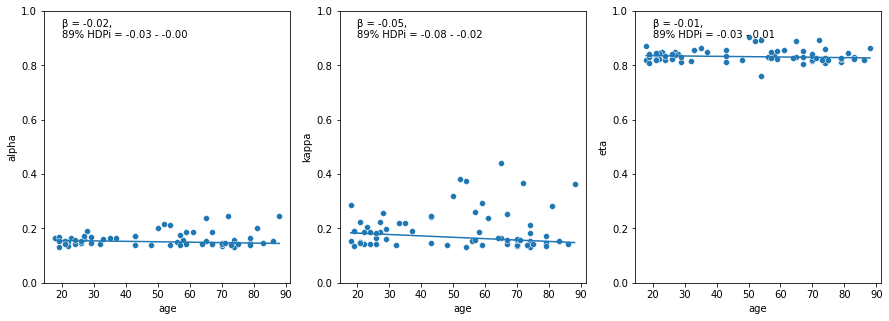

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(y = 'alpha',  x = 'age', data=learning, ax=axes[0])
sns.scatterplot(y = 'kappa', x = 'age', data=learning, ax=axes[1])
sns.scatterplot(y = 'eta', x = 'age', data=learning, ax=axes[2])

sns.lineplot(learning.age,alpha['mean']['intercept']+alpha['mean']['slope']*learning.age/100, ax=axes[0])
sns.lineplot(learning.age,kappa['mean']['intercept']+kappa['mean']['slope']*learning.age/100, ax=axes[1])
sns.lineplot(learning.age,eta['mean']['intercept']+eta['mean']['slope']*learning.age/100, ax=axes[2])

axes[0].set(ylim=(0,1))
axes[1].set(ylim=(0,1))
axes[2].set(ylim=(0,1))


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(alpha['mean']['slope']),
                                                        float(alpha['hdi_5.5%']['slope']),
                                                        float(alpha['hdi_94.5%']['slope']))
axes[0].text(20, .9, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(kappa['mean']['slope']),
                                                        float(kappa['hdi_5.5%']['slope']),
                                                        float(kappa['hdi_94.5%']['slope']))
axes[1].text(20, .9, text, fontsize=10)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(eta['mean']['slope']),
                                                        float(eta['hdi_5.5%']['slope']),
                                                        float(eta['hdi_94.5%']['slope']))
axes[2].text(20, .9, text, fontsize=12)

In [33]:
learning.to_csv('data/reversal_1st.csv')